# Generate & preprocess data

In [1]:
# Import packages
import pandas as pd  # Pandas is a library for processing data
import numpy as np   # Numpy is a library for working with numbers and arrays effectively
import random as rd  # To generate random dataset
from sklearn.decomposition import PCA
from sklearn import preprocessing   # Gives functions for preprocessing data, we will use it to scale the data before performing PCA
import matplotlib.pyplot as plt     # Matplotlib is a library for drawing graphs, we will use it to draw PCA graph

In [2]:
# Generate sample dataset
students = ['student' + str(i) for i in range(1,101)]     # Generate 100 students (such as student1, student2, ...). Note: range(1,101) generates values from 1 to 100, 101 is exclusive
maths = ['maths_' + str(i) for i in range(1,6)]        # We create 6 maths scores for each student
physics = ['physics_' + str(i) for i in range(1,6)]    # We create 6 physics scores for each student
data = pd.DataFrame(columns=[*maths, *physics], index=students)     # Create table with columns are the scores, and rows are the students. 
# The "*" unpacks the maths and physics arrays so that the column names are a single array like this: [maths_1, ..., maths_5, physics_1, ..., physics_5]
# Without the "*" you will have an array of 2 arrays, and we will not have 12 columns as we want: [[maths_1, ..., maths_5], [physics_1, ..., physics_5]]

for student in data.index:
  data.loc[student, 'maths_1':'maths_5'] = np.random.poisson(lam=rd.randrange(0,100), size=5)           # Use Poisson distribution (in numpy library) to generate random maths scores
  data.loc[student, 'physics_1':'physics_5'] = np.random.poisson(lam=rd.randrange(0,100), size=5)       

In [3]:
# Print the first 5 students to see the data
print(data.head())

         maths_1 maths_2 maths_3 maths_4 maths_5 physics_1 physics_2  \
student1      11       9       6       9       9        26        20   
student2      51      34      33      41      39        87        69   
student3      62      66      70      79      84        18        20   
student4      35      25      27      39      32        74        64   
student5      88      94      90      80      82        36        38   

         physics_3 physics_4 physics_5  
student1        19        27        23  
student2        89        77        68  
student3        14        20        27  
student4        56        68        58  
student5        42        44        38  


In [4]:
# The data shape should be (100,10), which is 100 students by 10 total score samples
print(data.shape)

(100, 10)


In [5]:
# Before doing PCA, we need to center and scale the data so that the mean of each student is 0, and the standard deviation of each student is 1

scaled_data = preprocessing.scale(data.T)     # We use transpose because the scale function expects the samples to be rows instead of columns

In [6]:
# Let's see the scaled maths_1 scores of the first 5 students
scaled_data[0][0:5]

array([-0.65079297, -0.37713298,  0.59275524, -0.74253135,  1.03462743])

# Perform PCA

In [7]:
# Create PCA model
pca = PCA()     # If n_components is not given, then all components are kept. In our case, we have 10 components: maths_1, ..., maths_5, physics_1, ..., physics_5

# Train the PCA 
pca.fit(scaled_data)    # This is where we do all the PCA math (i.e., calculate loading scores, variations, ...)
pca_data = pca.transform(scaled_data)   # This is where we generate the PCA graph based on loading scores and the scaled data

# Visualise the result

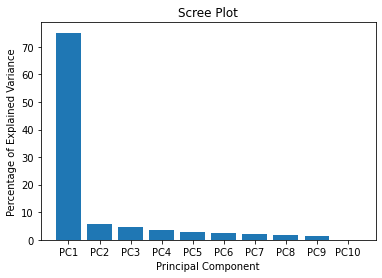

In [8]:
# Calculate the variations
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)      # This is to calculate the % of variation that each PC accounts for

# Draw scree plot
labels = ["PC" + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

We can notice that almost all of the variation is along PC1, so a 2D graph (using PC1 and PC2) will do a good job representing the original data.

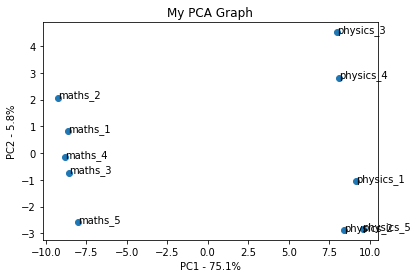

In [9]:
# Show the PCA graph
# We pass the new data coordinates created by the pca.transform() before, and set the rows to be sample labels, and the columns to be PC labels
pca_df = pd.DataFrame(pca_data, index=[*maths, *physics], columns=labels)
# Plot the graph
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
# Add sample names to the graph
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

We can see the physics scores clustered on the left side, indicating they are correlated to each other. Same for maths scores.

And the separation of the 2 clusters along x-axis suggests that physics scores are very different from maths scores.

Lastly, let's look at the loading scores of PC1 to see which students have the largest influence on separating the 2 clusters along the PC1-axis

In [10]:
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=students)   # A pandas Series object is just like a list in Python, but it supports more efficient dataset operations
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
# get the names of the top 10 influencer of PC1
top_10_students = sorted_loading_scores[0:10].index.values
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_students])

student58    0.114962
student63   -0.114705
student25   -0.114552
student29   -0.114463
student34   -0.114374
student21    0.114099
student5    -0.114096
student33   -0.114035
student16    0.113921
student8    -0.113921
dtype: float64


Those values are very close to each other, so a lot of students play the same role in separating the samples, rather than just 1 or 2.